Ufuk Altun

In [ ]:
%%shell
set -e

#---------------------------------------------------#
JULIA_VERSION="1.6.3" # any version ≥ 0.7.0
JULIA_PACKAGES="IJulia BenchmarkTools Plots"
JULIA_PACKAGES_IF_GPU="CUDA" # or CuArrays for older Julia versions
JULIA_NUM_THREADS=2
#---------------------------------------------------#

if [ -n "$COLAB_GPU" ] && [ -z `which julia` ]; then
  # Install Julia
  JULIA_VER=`cut -d '.' -f -2 <<< "$JULIA_VERSION"`
  echo "Installing Julia $JULIA_VERSION on the current Colab Runtime..."
  BASE_URL="https://julialang-s3.julialang.org/bin/linux/x64"
  URL="$BASE_URL/$JULIA_VER/julia-$JULIA_VERSION-linux-x86_64.tar.gz"
  wget -nv $URL -O /tmp/julia.tar.gz # -nv means "not verbose"
  tar -x -f /tmp/julia.tar.gz -C /usr/local --strip-components 1
  rm /tmp/julia.tar.gz

  # Install Packages
  if [ "$COLAB_GPU" = "1" ]; then
      JULIA_PACKAGES="$JULIA_PACKAGES $JULIA_PACKAGES_IF_GPU"
  fi
  for PKG in `echo $JULIA_PACKAGES`; do
    echo "Installing Julia package $PKG..."
    julia -e 'using Pkg; pkg"add '$PKG'; precompile;"' &> /dev/null
  done

  # Install kernel and rename it to "julia"
  echo "Installing IJulia kernel..."
  julia -e 'using IJulia; IJulia.installkernel("julia", env=Dict(
      "JULIA_NUM_THREADS"=>"'"$JULIA_NUM_THREADS"'"))'
  KERNEL_DIR=`julia -e "using IJulia; print(IJulia.kerneldir())"`
  KERNEL_NAME=`ls -d "$KERNEL_DIR"/julia*`
  mv -f $KERNEL_NAME "$KERNEL_DIR"/julia  

  echo ''
  echo "Success! Please reload this page and jump to the next section."
fi

yInstalling Julia 1.6.3 on the current Colab Runtime...
2021-11-07 09:52:17 URL:https://storage.googleapis.com/julialang2/bin/linux/x64/1.6/julia-1.6.3-linux-x86_64.tar.gz [113399344/113399344] -> "/tmp/julia.tar.gz" [1]
Installing Julia package IJulia...
Installing Julia package BenchmarkTools...
Installing Julia package Plots...
Installing Julia package CUDA...
Installing IJulia kernel...
[ Info: Installing julia kernelspec in /root/.local/share/jupyter/kernels/julia-1.6

Success! Please reload this page and jump to the next section.


# Checking the Installation
The `versioninfo()` function should print your Julia version and some other info about the system:

In [ ]:
versioninfo()

Install Knet

In [45]:
using Pkg; 
pkg"add Knet IterTools MLDatasets"
Pkg.add("FileIO")
Pkg.add("Images")

   Resolving package versions...
   Installed PkgVersion ──────────────── v0.1.1
   Installed WoodburyMatrices ────────── v0.5.5
   Installed OpenEXR ─────────────────── v0.3.2
   Installed ImageAxes ───────────────── v0.6.9
   Installed ProgressMeter ───────────── v1.7.1
   Installed ComputationalResources ──── v0.3.2
   Installed ImageMorphology ─────────── v0.2.11
   Installed Images ──────────────────── v0.24.1
   Installed UnPack ──────────────────── v1.0.2
   Installed IndirectArrays ──────────── v0.5.1
   Installed IfElse ──────────────────── v0.1.1
   Installed MKL_jll ─────────────────── v2021.1.1+2
   Installed Netpbm ──────────────────── v1.0.1
   Installed Parameters ──────────────── v0.12.3
   Installed Inflate ─────────────────── v0.1.2
   Installed Distances ───────────────── v0.10.6
   Installed SimpleTraits ────────────── v0.9.4
   Installed AxisArrays ──────────────── v0.4.4
   Installed Ratios ──────────────────── v0.4.2
   Installed FFTW ────────────────────── v1.4.

In [10]:
run(`gdown --id 1skwblH1_okBwxWxmRsp9_qi15hyPpxg8`)

Downloading...
From: https://drive.google.com/uc?id=1skwblH1_okBwxWxmRsp9_qi15hyPpxg8
To: /content/VLCS.tar.gz
100%|#####################################| 3.84G/3.84G [00:58<00:00, 66.0MB/s]


Process(`gdown --id 1skwblH1_okBwxWxmRsp9_qi15hyPpxg8`, ProcessExited(0))

In [22]:
#mkdir("/content/VLCS_data")
run(`tar xzf /content/VLCS.tar.gz`)

Process(`tar xzf /content/VLCS.tar.gz`, ProcessExited(0))

In [30]:
# Setup display width, load packages, import symbols
ENV["COLUMNS"]=72
using Base.Iterators: flatten
using IterTools: ncycle, takenth
using Statistics: mean
using MLDatasets: MNIST
using FileIO: load, save
using CUDA: CUDA, CuArray # functional
using Knet: Knet, conv4, pool, mat, nll, accuracy, progress, sgd, param, param0, dropout, relu, minibatch, Data

In [75]:
# Install packages before first run: using Pkg; pkg"add Knet IterTools MLDatasets"
#using Knet, IterTools, MLDatasets

using Images

function read_data(data_path,image_size,ssize)
i=1
first_r=true
y=[]
x=0
folders=readdir(data_path)
for class in folders
    println("Class number ",i," ",class)
    directory=string(data_path,"/",class)
    counter = 0
    for img in readdir(directory)
        arr_img=load(string(directory,"/",img))
        #print(size(arr_img))
        if size(arr_img) != image_size
          arr_img = imresize(arr_img, image_size);
        end
        arr_img=channelview(arr_img)
        arr_img = permutedims(arr_img, (2, 3, 1))
        #arr_img=image_data(arr_img,image_size)

        label=zeros(size(folders))
        label[i]=1
        if first_r==false
            x=cat(x,arr_img,dims=4)
        else
            x=cat(arr_img,dims=4)
        end
        push!(y,i)
        first_r=false
        counter = counter + 1;
        if counter == ssize
            break
        end
    end
    i+=1
    end
println(size(y))
println(size(x))
return x,y;
end

# Load MNIST data
#xtrn,ytrn = MNIST.traindata(Float32); ytrn[ytrn.==0] .= 10
#xtst,ytst = MNIST.testdata(Float32);  ytst[ytst.==0] .= 10
#dtrn = minibatch(xtrn, ytrn, 100; xsize = (28,28,1,:))
#dtst = minibatch(xtst, ytst, 100; xsize = (28,28,1,:));

xtrn,ytrn=read_data("VLCS/SUN09",(227,227), 40); #load images
xtst,ytst=read_data("VLCS/SUN09",(227,227), 10); #load images
dtrn = minibatch(xtrn, ytrn, 100; xsize = (227,227,3,:))
dtst = minibatch(xtst, ytst, 100; xsize = (227,227,3,:));

# For running experiments
function trainresults(file,model; o...)
    if (print("Train from scratch? "); readline()[1]=='y')
        r = ((model(dtrn), model(dtst), 1-accuracy(model,dtrn), 1-accuracy(model,dtst))
             for x in takenth(progress(sgd(model,ncycle(dtrn,100))),length(dtrn)))
        r = reshape(collect(Float32,flatten(r)),(4,:))
        save(file,"results",r)
        GC.gc(true) # To save gpu memory
    else
        isfile(file) || download("https://github.com/denizyuret/Knet.jl/releases/download/v1.4.9/$file",file)
        r = load(file,"results")
    end
    println(minimum(r,dims=2))
    return r
end

# Define a convolutional layer:
#struct Conv; w; b; f; p; end
#(c::Conv)(x) = c.f.(pool(conv4(c.w, dropout(x,c.p)) .+ c.b))
#Conv(w1::Int,w2::Int,cx::Int,cy::Int,f=relu;pdrop=0) = Conv(param(w1,w2,cx,cy), param0(1,1,cy,1), f, pdrop)

# Define convolutional layer:
struct Conv; w; b; end
Conv(w1,w2,nx,ny) = Conv(param(w1,w2,nx,ny), param0(1,1,ny,1))
(c::Conv)(x) = relu.(pool(conv4(c.w, x) .+ c.b))

# Redefine dense layer (See mlp.ipynb):
#struct Dense; w; b; f; p; end
#(d::Dense)(x) = d.f.(d.w * mat(dropout(x,d.p)) .+ d.b) # mat reshapes 4-D tensor to 2-D matrix so we can use matmul
#Dense(i::Int,o::Int,f=relu;pdrop=0) = Dense(param(o,i), param0(o), f, pdrop)

# Define dense layer:
struct Dense; w; b; f; end
Dense(i,o; f=identity) = Dense(param(o,i), param0(o), f)
(d::Dense)(x) = d.f.(d.w * mat(x) .+ d.b)


# Let's define a chain of layers
struct Chain
    layers
    Chain(layers...) = new(layers)
end
(c::Chain)(x) = (for l in c.layers; x = l(x); end; x)
(c::Chain)(x,y) = nll(c(x),y)
(c::Chain)(d::Data) = mean(c(x,y) for (x,y) in d)

# Define a chain of layers and a loss function:
#struct Chain; layers; end
#(c::Chain)(x) = (for l in c.layers; x = l(x); end; x)
#(c::Chain)(x,y) = nll(c(x),y)


#lenet =   Chain(Conv(5,5,1,20), 
#                Conv(5,5,20,50), 
#                Dense(800,500,pdrop=0.3), 
#                Dense(500,10,identity,pdrop=0.3))
#summary.(l.w for l in lenet.layers)

# Define and train LeNet (~10 secs on a GPU or ~3 mins on a CPU to reach ~99% accuracy)
#progress!(adam(LeNet, ncycle(dtrn,3)))
#accuracy(LeNet,data=dtst)




Class number 1 bird
Class number 2 car
Class number 3 chair
Class number 4 dog
Class number 5 person
(170,)
(227, 227, 3, 170)
Class number 1 bird
Class number 2 car
Class number 3 chair
Class number 4 dog
Class number 5 person
(50,)
(227, 227, 3, 50)


In [77]:
LeNet = Chain((Conv(3,3,3,20), Conv(3,3,20,50), Dense(80,50,f=relu), Dense(500,5)))
AlexNET = trainresults("cnn113.jld2", LeNet);

Train from scratch? stdin> y

Stacktrace:
  [1] conv4(w::KnetArray{Float32, 4}, x::Array{N0f8, 4}; padding::Int64, stride::Int64, dilation::Int64, mode::Int64, alpha::Int64, group::Int64)
    @ Knet.Ops20 ~/.julia/packages/Knet/RCkV0/src/ops20/conv.jl:39
  [2] conv4(w::KnetArray{Float32, 4}, x::Array{N0f8, 4})
    @ Knet.Ops20 ~/.julia/packages/Knet/RCkV0/src/ops20/conv.jl:34
  [3] forw(::Function, ::Param{KnetArray{Float32, 4}}, ::Vararg{Any, N} where N; kwargs::Base.Iterators.Pairs{Union{}, Union{}, Tuple{}, NamedTuple{(), Tuple{}}})
    @ AutoGrad ~/.julia/packages/AutoGrad/TTpeo/src/core.jl:66
  [4] forw
    @ ~/.julia/packages/AutoGrad/TTpeo/src/core.jl:65 [inlined]
  [5] #conv4#28
    @ ./none:0 [inlined]
  [6] conv4(w::Param{KnetArray{Float32, 4}}, x::Array{N0f8, 4})
    @ Knet.Ops20 ./none:0
  [7] (::Conv)(x::Array{N0f8, 4})
    @ Main ./In[75]:82
  [8] (::Chain)(x::Array{N0f8, 4})
    @ Main ./In[75]:100
  [9] (::Chain)(x::Array{N0f8, 4}, y::Vector{Any})
    @ Main ./In[75]:10

LoadError: ignored

In [51]:
using Images

function read_data(data_path,image_size, ssize)
i=1
first_r=true
y=[]
x=0
folders=readdir(data_path)
for class in folders
    println("Class number ",i," ",class)
    directory=string(data_path,"/",class)
    counter = 0
    for img in readdir(directory)
            
        arr_img=load(string(directory,"/",img))
        #print(size(arr_img))
        if size(arr_img) != image_size
          arr_img = imresize(arr_img, image_size);
        end

        #arr_img=image_data(arr_img,image_size)

        label=zeros(size(folders))
        label[i]=1
        if first_r==false
            x=cat(x,arr_img,dims=4)
        else
            x=cat(arr_img,dims=4)
        end
        push!(y,i)
        first_r=false
        counter = counter + 1;
        if counter = ssize
            break
        end
    end
    i+=1
    end
println(size(y))
println(size(x))
return x,y;
end

read_data (generic function with 2 methods)

In [62]:
AlexNET = trainresults("cnn113.jld2", LeNet);

Train from scratch? stdin> y


LoadError: ignored

┌ Info: Precompiling GR_jll [d2c73de3-f751-5644-a686-071e5b155ba9]
└ @ Base loading.jl:1342
ERROR: LoadError: LoadError: InitError: could not load library "/root/.julia/artifacts/a84cc58d5161b950f268bb562e105bbbf4d6004a/lib/libGL.so"
/root/.julia/artifacts/a84cc58d5161b950f268bb562e105bbbf4d6004a/lib/libGL.so: undefined symbol: _glapi_tls_Current
Stacktrace:
  [1] dlopen(s::String, flags::UInt32; throw_error::Bool)
    @ Base.Libc.Libdl ./libdl.jl:114
  [2] dlopen(s::String, flags::UInt32)
    @ Base.Libc.Libdl ./libdl.jl:114
  [3] macro expansion
    @ ~/.julia/packages/JLLWrappers/bkwIo/src/products/library_generators.jl:54 [inlined]
  [4] __init__()
    @ Libglvnd_jll ~/.julia/packages/Libglvnd_jll/pJrjy/src/wrappers/x86_64-linux-gnu.jl:22
  [5] _include_from_serialized(path::String, depmods::Vector{Any})
    @ Base ./loading.jl:696
  [6] _require_search_from_serialized(pkg::Base.PkgId, sourcepath::String)
    @ Base ./loading.jl:782
  [7] _require(pkg::Base.PkgId)
    @ Base ./load

Your GR installation is incomplete. Rerunning build step for GR package.


┌ Error: Error importing GR_jll:
│   err = ErrorException("Failed to precompile GR_jll [d2c73de3-f751-5644-a686-071e5b155ba9] to /root/.julia/compiled/v1.6/GR_jll/jl_UoAq51.")
└ @ GR /root/.julia/packages/GR/SOvTP/src/funcptrs.jl:42
┌ Info: Switching provider to GR due to error in depsfile
│   depsfile = /root/.julia/packages/GR/SOvTP/deps/deps.jl
└ @ GR /root/.julia/packages/GR/SOvTP/src/GR.jl:355
┌ Info: Emptying depsfile. GR provider is GR
│   provider = GR
│   depsfile = /root/.julia/packages/GR/SOvTP/deps/deps.jl
└ @ GR.Builder /root/.julia/packages/GR/SOvTP/deps/build.jl:128
┌ Info: Downloading pre-compiled GR 0.62.0 Ubuntu binary
└ @ GR.Builder /root/.julia/packages/GR/SOvTP/deps/build.jl:193


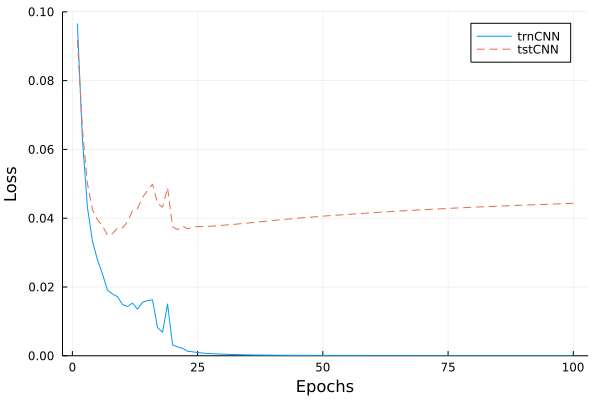

┌ Info: GR was successfully rebuilt
└ @ GR /root/.julia/packages/GR/SOvTP/src/GR.jl:364


In [40]:
using Plots; default(fmt=:png,ls=:auto)

# Comparison to MLP shows faster convergence, better generalization
plot([AlexNET[1,:], AlexNET[2,:]],ylim=(0.0,0.1),
     labels=["trnCNN" "tstCNN"],xlabel="Epochs",ylabel="Loss")

